# Baiscs of mobile robotics Project

Group n°32
Students: 
- Konstantin Dinev (314419)
- Owen Timothy Claude Simon (330807)
- Jiarui Yu (351440)
- Jeffrey Siyuan Yu (371327)

## Introduction

### General story

Long ago in the mountains close to Monte Tamaro, our adventurous friend, Little Thymio, a spirited red triangle robot, was on a quest to reunite with his pals at the meeting point – the 'Blue Circle'. His more experienced friends offered him help, perched at a higher altitude and acting as the guiding camera. However, Little Thymio quickly discovered that blindly following his friend's advices wasn't always the ideal approach. Challenges were all around him (represented by black rectangles), and waiting for guidance wasn't always an option. Little Thymio had to rely on his instincts (embeded sensors) and quick thinking to navigate the obstacles that layed ahead.
In the long trip there were moments when Thymio's friends were caught up in distractions, and couldn't provide immediate guidance. Without the watchful eye of his friends, Little Thymio had to trust his own senses to make split-second decisions, dodging traps like local obstacles. Adding to the complexity, the unpredictable terrain occasionally led Little Thymio astray. The journey back to his buddies at the blue circle became a test of his problem-solving skills, figuring out the shortest and most efficient path through turns of the mountains. The successful completion of Little Thymio and his friends' group project was a result of their hard work, cooperation, and thoughtful consideration of various factors.



<div align=center>
<img src="./figs/top_down_thymio_env.png" style="width:50%"/>
<figcaption>Thymio, obstacle and marker setup</figcaption>
</div>

The real environment setting is shown as below 



## Convention settings

The convention setting for the coordinates is show as below:

<div align=center>
<img src="./figs/convention_setting.jpeg" style="width:50%"/>
<figcaption>Convention setting</figcaption>
</div>

## Vision

The image processing steps are aimed at identifying and understanding different elements in a scene. The camera is mounted above the environment infront of the environment, so it is looking down at an angle. Initially, the program detects green squares, which serve as reference points for transforming the entire image. This transformation projects the view so that it appears like it is looking straight down. After transforming the image, all the detection is performed on the transformed image. The process then involves recognizing obstacles in black, identifying the goal in blue, and pinpointing the robot through a distinctive red triangle.
Originally, we attempted to use QR code detection for localization, but it proved less reliable. Subsequently, we turned to Aruco markers, which worked well for a smaller robot map. However, as the map size increased, the camera struggled to consistently detect QR codes in each frame. This challenge led us to adopt a simpler approach, using colored triangles to represent the robot's location.

After switching the Thymio to a triangle, we still had issues with detection. The camera only detected the Thymio triangle approximately one out of 30 loops. To resolve this, we plotted the original image and the masks. Immediately, we noticed the first frame of the video captured always had a blue hue, but the mask clearly detected the triangle. From the second capture onwards, the camera lost the hue and the mask could not detect any triangle. We confirmed this behavior by running the script multiple times. To resolve this issue, we added a statement to ignore the first 50 frames from the webcam upon startup. This solved the issue with the Thymio detection.

### Image processing and segmentation

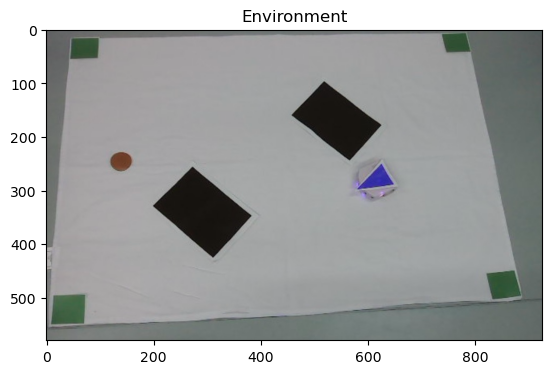

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('default')

# Load and display the iamge
filename = './figs/layout.jpeg'
image = cv2.imread(filename)
plt.imshow(image)
plt.title("Environment")
plt.axis('on')
plt.show()

The image processing steps aim at identifying and understanding different elements in the scene. Initially, the focus is on detecting green squares, which serve as reference points for transforming the entire image. The process then involves recognizing obstacles in black, identifying the goal in blue, and pinpointing the robot through a distinctive red triangle.
Originally, we attempted to use QR code detection for localization, but it proved less reliable. Subsequently, we turned to Aruco markers, which worked well for a smaller robot map. However, as the map size increased, the camera struggled to consistently detect QR codes in each frame. This challenge led us to adopt a more home-made approach, using colored triangles to represent the robot's location and use segmentation to find it.

<div align="center">
  <img src="./figs/legend.png" style="width:50%" />
  <figcaption>Layout legend</figcaption>
</div>

The image processing pipeline involves the following steps:

1. Perspective transform
2. Convert the image to the HSV (Hue, Saturation, Value).
3. Generate a binary mask using threshold values for each color channel (Blue, Green, Red) in the HSV image.
4. Perform morphological operations on the mask:
   - Dilate the mask
   - Erode
5. Apply median blur filter.
6. Perform edge detection using the Canny edge detector:
    - Dilate the edges to enhance the detected features.

We designed this image processing pipeline for extracting the features in a color-based environement. It is done via segmentation and edge detection. 

note: The threshold values and kernel sizes  are found trough iterative testing ans are specific of our application and can be modified based on the requirements and the camera.

### Perspective transform

Using a mask and the image processing steps explained in the previous section we manage to extract the four biggest green contours which dont have the same center. Then the centers of these 4 green rectangles are used as destination points in the 'cv2.getPerspectiveTransform' which gives us the transformation matrix.

<div align="center">
  <img src="./figs/Transform_theoryfinale.png" style="width:90%" />
  <figcaption> Demonstration of the transformation</figcaption>
</div>

After obtaining the transformation matrix, we proceed by projecting each pixel from the original camera frame into the new space. This is done with the OpenCV function 'cv2.warpPerspective', which takes as input the original image and the transformation matrix. Our group decided on this projection method to achieve a clearer and more consistent view of the entire setup. This choice results in a top view of the setup. In the final submission, we display both the projected and initial images, providing a diverse perspective for a comprehensive understanding. In the projected image below, each corner corresponds to the center of a green square. This arrangement ensures that every center of a green square is positioned at one of the image's corners.

<div align="center">
  <img src="./figs/projected_BGR.jpeg" style="width:50%" />
  <figcaption> Projected BGR image</figcaption>
</div>

### HSV image

The camera frame provided by 'cv2.VideoCapture(camera_id)' is in  the BGR color space. We did asit is common in most computer vision task to transform to HSV space in this way we were able to separate color information from brightness. This made the image processing steps more robust to change in the light conditions.

<div align="center">
  <img src="./figs/BGR.jpeg" style="width:50%" />
  <figcaption>BGR image</figcaption>
</div>

### Binary mask

**Empirical Approach for thresholding**

Eventough utilizing HSV images that are more resilient to changes in light intensity. We required the creation of a mask for subsequent segmentation of different image parts (robot center, obstacles, goal etc.). Through a Python script designed for threshold identification, we successfully determined suitable thresholds. This calibration is done when there are variations in the background, luminosity, and camera settings.
The process entails selecting a series of thresholds $T_0  < F <  T_1$ for each individual RGB channel and generating a mask using 'cv2.inRange()'. The mask assigns all regions to white if the color threshold is true and sets them to black elsewhere.

For each pixel $(k, l)$ , we simultaneously ensure that the thresholds are satisfied for each color channel (Red, Green, Blue).

1) $f_{\text{red}}[k, l] =
\begin{cases} 
1 & \text{if } T_{\text{min}_{\text{Red}}} \leq f_{\text{Red}}[k, l] < T_{\text{max}_{\text{Red}}} \\
0 & \text{otherwise}
\end{cases} $

2)  $f_{\text{red}}[k, l] = 
\begin{cases} 
1 & \text{if } T_{\text{min}_{\text{Green}}} \leq f_{\text{Green}}[k, l] < T_{\text{max}_{\text{Green}}} \\
0 & \text{otherwise}
\end{cases} $

3)  $f_{\text{red}}[k, l] = 
\begin{cases} 
1 & \text{if } T_{\text{min}_{\text{Blue}}} \leq f_{\text{Blue}}[k, l] < T_{\text{max}_{\text{Blue}}} \\
0 & \text{otherwise}
\end{cases} $

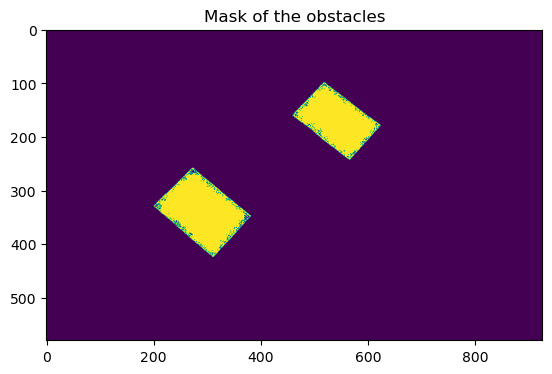

In [47]:
# Defining the the RGB threshold values for the obstacles
(min_blue_obst, min_green_obst, min_red_obst) = (0, 0, 0)
(max_blue_obst, max_green_obst, max_red_obst) = (255, 171, 29)
    
# HSV (Hue, Saturation, Value): Separates the color information from the brightness information, making it robust to changes in lighting conditions
hsv_frame = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# getting the mask image from the HSV image using threshold values
mask = cv2.inRange(hsv_frame, (min_blue_obst, min_green_obst, min_red_obst), (max_blue_obst, max_green_obst, max_red_obst))
plt.imshow(mask)
plt.title("Mask of the obstacles")
plt.axis('on')
plt.show()

### Morphological operations

Performing morphological operations on the mask involves dilating and then eroding it. Dilating the mask helps fill holes and gaps within the regions of interest, making the features more connected and robust. However, dilation can also cause the regions to expand, so subsequent erosion is applied to maintain the original size while still benefiting from the hole-filling effect, resulting in a refined and enhanced mask.

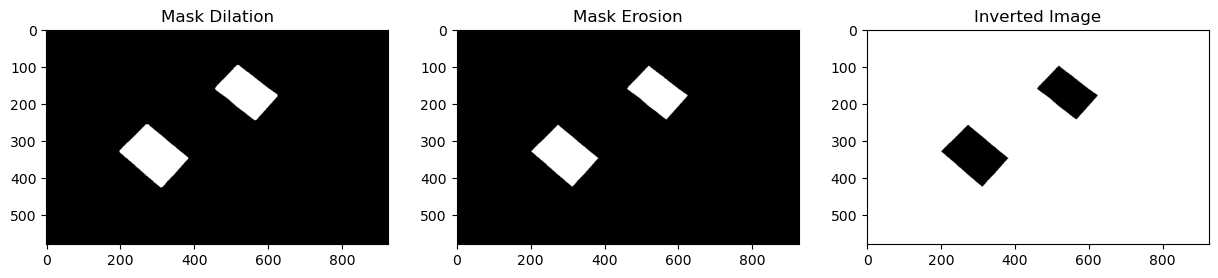

In [48]:
kernel = np.ones((5, 5), np.uint8)
kernel_size = 5

mask_dilation = cv2.dilate(mask, kernel, iterations=1)
mask_erosion = cv2.erode(mask_dilation, kernel, iterations=1)
inverted_image = cv2.bitwise_not(mask_erosion)

# Create a 1x3 subplot
plt.figure(figsize=(15, 5))

# Original Mask
plt.subplot(131)
plt.imshow(mask_dilation, cmap='gray')
plt.title("Mask Dilation")
plt.axis('on')

# Mask Dilation
plt.subplot(132)
plt.imshow(mask_erosion, cmap='gray')
plt.title("Mask Erosion")
plt.axis('on')

# Inverted Image
plt.subplot(133)
plt.imshow(inverted_image, cmap='gray')
plt.title("Inverted Image")
plt.axis('on')

# Show the figure
plt.show()

### Apply median blur filter


Due to significant noise and suboptimal segmentation of different parts of the image, additional preprocessing steps were necessary, particularly in addressing salt and pepper noise likely originating from the camera and lighting conditions. To enhance image quality and reduce noise, a median blur filter was applied, resulting in improved segmentation outcomes.

### Edge detection


Some key steps in the Canny edge detection algorithm involve applying a Gaussian blur filter with a kernel size of 5x5 before determining intensity gradients. This filtering is essential to enhance the robustness of the algorithm. By smoothing the image, the Gaussian filter mitigates noise, in this way the computation of intensity gradients will be more accurate. Subsequently, thresholding is applied to identify edges, taking advantage of the improved gradient information

After performing edge detection using the Canny edge detector, the subsequent step involves dilating the detected edges. Using dilation operation we aim to enhance the features identified by the edge detector, emphasizing and expanding the edges for better visibility therefor it will be easier for the subsequent analysis.

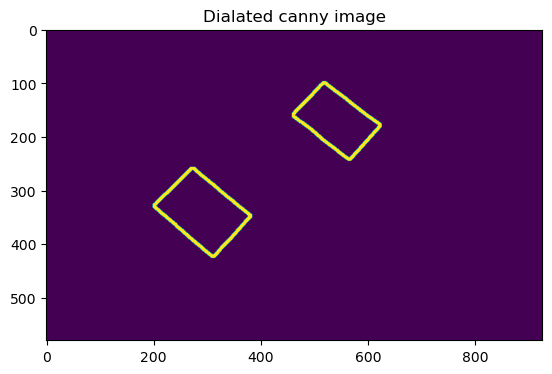

In [49]:
lower_threshold = 100
upper_threshold = 150
aperture_size = 7

canny_img = cv2.Canny(inverted_image, lower_threshold, upper_threshold, apertureSize=aperture_size, L2gradient=True)
dilated_edges = cv2.dilate(canny_img, kernel, iterations=1)
plt.imshow(dilated_edges)
plt.title("Dialated canny image")
plt.axis('on')
plt.show()

### Contour identification

We employ the 'findContours()' function from OpenCV to identify continuous closed curves, which we utilize for shape recognition. The following code snippet illustrates how obstacles could be detected. In our project, we similarly analyze the number of edges in the closed contour to determine whether it represents a circle, triangle, or rectangle. As in most of the cases the contours are realy complicated with many edges, we used the function 'approxPolyDP()' to approximate the contour shapes to transform them with less number of vertices. This function is based on the Douglas–Peucker algorithm.

In [50]:
# Initialising the number of contours
num_obstacles = 0

# Finding the closed contours
(obstacle_contours, _) = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Cheking the numbers of contours that have 4 edges as we want to identify rectangle obstacles
for cnt in obstacle_contours:
    peri = cv2.arcLength(cnt, True)
    vertices = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    sides = len(vertices)
    if sides == 4:
            num_obstacles += 1
            
print('The number of obstacles is', num_obstacles)

The number of obstacles is 2


### Finding Thymio Position and Orientation

The process of finding the little Thymio contour (red triangle) is proceeded as above. 

Once the vertices are extracted, the function *find_thymio_position_angle* finds the shortest side of the triangle, which will be referred to as the back of the triangle. Once the shortest side of the triangle is known, the front, denoted as $F$, is determined as the vertex that does not define the shortest edge of the triangle. To find the angle of the triangle, a line is drawn from the front of the triangle to the center of the back edge of the triangle, $C_b$. Then the arctangent of that line is taken, which returns $\theta$. This theta however wrong in the coordinate plane we use, so we must use $\theta_N$ to align with our own convention. The position of the triangle is defined as the middle of the triangle $M$, which is found as the midpoint between $F$ and $C_b$. Just as below, the picture illustrates the points mentioned. 

<div align=center>
<img src="./figs/triangle_position_and_angle_new2.png" style="width:40%"/>
<figcaption>Visualization of triangle annotated triangle used to determine position and angle </figcaption>
</div

### Expanding the obstacles size

After detecting the obstacles, their boundaries need to be expanded to account for the size of the Thymio. This is because the global path planning algorithm uses the vertices of the obstacles and the center of the Thymio to create the path. Consequently, the distance from the Thymio's center to its farthest edge must be added to every point on the obstacle to prevent collisions.

The most effective approach is to find the Minkowski sum of the rectangle shape and the Thymio shape.However, for practical reasons, we decided to scale the contours manually because this allows us to account for any overshooting with the astolfi controller that we had when testing.

This scaling method achieves optimal scaling on shapes that are symmetric across the x and y axis, ex. squares, equilateral pentagons etc... This is because the scaling of is performed uniformly in the x and y directions. In the beginning, we tried with triangle obstacles, but due to the previously mentioned considerations, we just decided to use rectangles, which does not scale equivalently as seen in the image below, but we could create more complex trajectories with this  shape.

<div align=center>
<img src="./figs/scaled_contour.png" style="width:40%"/>
<figcaption>Image of scaled contours</figcaption>
</div>

In [ ]:
# INPUTS: a contour
def scale_contour(original_contour):
    # Get the bounding rectangle around the shape
    x, y, w, h = cv2.boundingRect(original_contour)

    # Calculate the center of the bounding rectangle
    center = ((x + w // 2), (y + h // 2))

    
    scale_factor = 1.7

    
    scaled_contour = np.array([[(point[0][0] - center[0]) * scale_factor + center[0],
                                    (point[0][1] - center[1]) * scale_factor + center[1]]
                                   for point in original_contour], dtype=np.int32)

    return scaled_contour

## Global navigation

Global navigation is used to create the shortest path to the destination. The shortest path is determined by the smallest euclidean distance. The solution two-fold, first create a visibility graph with the current location of the thymio, the expanded vertices of the obstacles, and the center of the goal as nodes. A node is connected to another if there is a direct path between them. 

After creating the adjacency graph, a shortest path algorithm can be used, A-star or Dijkstra for example. In this application, after we understood a method to find the shortest path, we used a library PyVisGraph to help with implementation of creating a visibility graph and finding the shortest path. This library employs Dijkstra's algorithm. While we acknowledge that A-star is more computationally efficient, for the current application, Dijkstra's algorithm demonstrated satisfactory speed performance within the computational capabilities of a laptop. 

<div align=center>
<img src="./figs/image_with_path_drawn.jpg" style="width:40%"/>
<figcaption>Image of global optimal path drawn after processing the image</figcaption>
</div>

In [ ]:
# INPUTS: vertices of obstacles, the robot position, goal position
def get_shortest_path(shape_vertices, rob_pos, goal_pos):
    polygons = []
    for shape in shape_vertices:
        polygon = []
        for point in shape:
            polygon.append(vg.Point(point[0], point[1]))
        polygons.append(polygon)

    # creating the visibility graph
    graph = vg.VisGraph()
    graph.build(polygons)

    startPosition = vg.Point(rob_pos[0], rob_pos[1])
    endPosition = vg.Point(goal_pos[0], goal_pos[1])

    shortestPath = graph.shortest_path(startPosition, endPosition)
    return shortestPath

## Thymio Class and Motion Control

For this project and for the control of the Thymio, we had the vision of a wrapper class for the node and the client that would take care of everything in a very modular way. We opted to create another more semantic wrapper of AsyncClientInterface called ThymioRobot, with AsyncClientInterface serving as a lower level class.

The AsyncClientInterface class is in the file called AsyncClientInterface.py under the dependencies foler.

We will start by analysing the Initialisation. The constructor and destructor takes the seven lines of code below and automates them.

In [ ]:
from tdmclient import ClientAsync

client = ClientAsync()
node = aw(client.wait_for_node())
aw(node.lock())
# Code to desactivate leds on start
aw(node.compile("""call leds.prox.v(0, 0)\ncall leds.prox.h(0, 0, 0, 0, 0, 0, 0, 0)\ncall leds.temperature(0, 0)\ncall leds.top(0, 0, 0)\ncall leds.circle(0, 0, 0, 0, 0, 0, 0, 0)\ncall leds.buttons(0, 0, 0, 0)\ncall leds.sound(0)\ncall leds.rc(0)"""))

aw(node.unlock())

giving us this code instead.

In [ ]:
from dependencies.AsyncClientInterface import AsyncClientInterface

AsyncClient = AsyncClientInterface()

It is important to note that AsyncClient instance does not follow normal naming convention (lower_case) as we consider it to be more of an interface than a proper object.


Through this class we aimed to control the motors through a very permissive method. We had to work around the problem of overriding functions as in C++, in Python, we therefore have to use args, kwargs and some additional logics.

In [ ]:
def set_motors(self, *args, **kwargs) -> None:
        """
        A flexible function that lets you input the speed of the motors

        :param args: left_motor then right_motor
        :type args: int
        :param kwargs: can put in right_motor or left_motor value in directly or put in array with length 2
        :type kwargs: int or list[int, int]

        :return: None
        """
        if len(args) == 2:
            aw(self.node.set_variables({
                self.LEFT_MOTOR: [args[0]],
                self.RIGHT_MOTOR: [args[1]]
            }))

        elif len(args) == 1:
            aw(self.node.set_variables({
                self.LEFT_MOTOR: [args[0]]
            }))

        if 'left_motor' in kwargs:
            if isinstance(kwargs['left_motor'], int):
                aw(self.node.set_variables({
                    self.LEFT_MOTOR: [kwargs['left_motor']]
                }))
            else:
                raise TypeError("value attributed to left_motor was not int")

        if 'right_motor' in kwargs:
            if isinstance(kwargs['right_motor'], int):
                aw(self.node.set_variables({
                    self.RIGHT_MOTOR: [kwargs['right_motor']]
                }))
            else:
                raise TypeError("value attributed to right_motor was not int")
        if 'motor' in kwargs:
            if isinstance(kwargs['motor'], list) and len(kwargs['motor']) == 2:
                aw(self.node.set_variables({
                    self.LEFT_MOTOR: [int(kwargs['motor'][0])],
                    self.RIGHT_MOTOR: [int(kwargs['motor'][1])]
                }))
            else:
                raise TypeError("either array too long or too short or did not respect type list")

We can notice that the internal function code uses variables such as self.LEFT_MOTOR and self.RIGHT_MOTOR which are set to motor.left.target and motor.right.target respectively. These are put under the form of variables to avoid magic strings, therefore making the code more readable. This allows the function to be called in different ways.

In [ ]:
AsyncClient.set_motors(50, 50)
AsyncClient.set_motors(left_motor=100, right_motor=100)
AsyncClient.set_motors(motor=[100, 100])

AsyncClient.set_motors(0, 0)

We will skip over the functions that have not been used for the project we decided to keep them because they are a nice addition and could have potentially been useful.

The polyvalent function **get_sensor** enables us to get the value of any sensor.

In [ ]:
    def get_sensor(self, sensor: str, calibrated: bool = False) -> list[int] | int | bool:
        """
        This is a function that returns the value of the sensor it accepts only a string and uses a switch case method


        :param sensor : Accepts  a limited number of strings\
            - 'prox_del' : this presents the array of prox ground delta with the option of calibration\
            - 'prox_ref' : this presents the array of prox ground reflected with the option of calibration\
            - self.CONSTANT: this is presented in the example in the description

        :type sensor: str

        :return: returns the value or array of a sensor, or returns False if invalid string is passed as argument
        :rtype: list[int] or int or bool or list[bool]

        Example:

        >>>Client = AsyncClientInterface(1.35,1.35)

        >>>print(Client.get_sensor(Client.PROX_GROUND_DELTA))
        """
        if sensor == "prox_del":
            aw(self.node.wait_for_variables({self.PROX_GROUND_DELTA}))
            if calibrated:
                calibrated_sensor_2 = int(list(self.node.v.prox.ground.delta)[1]) * self._delta_calib
                return [int(list(self.node.v.prox.ground.delta)[0]), int(calibrated_sensor_2)].copy()
            else:
                return list(self.node.v.prox.ground.delta).copy()

        elif sensor == "prox_ref":
            aw(self.node.wait_for_variables({self.PROX_GROUND_REFLECTED}))
            if calibrated:
                calibrated_sensor_2 = int(list(self.node.v.prox.ground.reflected)[1]) * self._refl_calib
                return [int(list(self.node.v.prox.ground.reflected)[0]), int(calibrated_sensor_2)].copy()
            else:
                return list(self.node.v.prox.ground.reflected).copy()

        else:
            aw(self.node.wait_for_variables({sensor}))
            attributes = sensor.split(".")
            node_with_attr = getattr(self.node, "v")
            for attribute in attributes:
                node_with_attr = getattr(node_with_attr, attribute)

            try:
                if not type(node_with_attr) == int:
                    return list(node_with_attr)
                else:
                    return node_with_attr
            except AttributeError:
                raise InvalidArgumentError("attribute was not found due to wrong input being put in")

There are two sensors which needed calibration on the thymio, we added a special condition which can be found with "prox_del" and "prox_refl". They follow the Thymio documentation to get the values of sensors from the node with the added specificity of adding. They were not used for the project so we will not look at them in detail here.


In the upcoming section of code we split the code at full stops present in the incoming string and then use getattr function imported from python in order to emulate calling attributes of node.v., if we call the function with "motor.left.speed" the code will fetch node.v.motor.left.speed.

In [ ]:
else:
    aw(self.node.wait_for_variables({sensor}))
    attributes = sensor.split(".")
    node_with_attr = getattr(self.node, "v")
    for attribute in attributes:
        node_with_attr = getattr(node_with_attr, attribute)

    try:
        # logic checking whether to cast and handling errors
        if not type(node_with_attr) == int:
            return list(node_with_attr)
        else:
            return node_with_attr
    except AttributeError:
        raise InvalidArgumentError("attribute was not found due to wrong input being put in")

Enabling us to write lean code such as

In [ ]:
print(AsyncClient.get_sensor(AsyncClient.LEFT_SPEED))
print(AsyncClient.get_sensor(AsyncClient.PROX_HORIZONTAL_VALUES))

Then we tpu in set_led function which enables to set the leds and checks for 3 values.

In [ ]:
    def set_led(self, sensor: str, value: int | list[int]) -> None:
        """
        A function that enables you to set sensors through the node.set_variables method the leds expect values between 0 and 32
        :param sensor: input your sensor
            - 'leds_top': expects three rgb values

        :param value: a list or an array containing the values you want to output
        """

        if sensor == "leds_top":
            if isinstance(value, list) and len(value) == 3:
                aw(self.node.wait_for_variables({"leds.top"}))
                for index, rgb in enumerate(value):
                    self.node.v.leds.top[index] = rgb
            else:
                raise TypeError("either did not input list or list was not of right length")

        self.node.flush()

We can then set the upper leds to blue with this bit of code.

In [ ]:
AsyncClient.set_led("leds_top",[0, 0, 32])
AsyncClient.set_led("leds_top", [0, 0, 0])

#### The ThymioRobot class

It is important to note that for this class we get values for position (x-axis postion, y-axis position and orientation) and goal that use the main convention of the class which we then had to convert into the astolfi conventions. Therefore we inherit a position which is an array with $[x,y,\theta]$ and we have to convert it into $[x,y,\theta\pm\pi]$ to then be able to apply the controller.

The code for the ThymioRobot class can be found in the file called ThymioRobot.py under thymio_movement folder.

#### Astolfi controller and local navigation


Now we are going to explain the apply_motor_command and the local_nav command.

In [ ]:
def apply_motor_command(self):
        """
        Applies the astolfi command in accordance to the goal and the position we have given to
        """
        movement_vector = self.goal - self._position
        rho = np.sqrt(movement_vector[1] ** 2 + movement_vector[0] ** 2)
        if rho < self.__THRESHOLD:
            self.on_objective = True
            return
        # we add np.pi to position[2] in order to adapt to the different astolfi referential
        alpha = convert_angle(-self._position[2] + np.pi + np.arctan2(-movement_vector[1], movement_vector[0]))
        beta = convert_angle(- self._position[2] - alpha + np.pi)
        forward_speed = self.__KAPPA_RHO * rho
        turning_velocity = (self.__WHEEL_DISTANCE / 2) * (self.__KAPPA_ALPHA * alpha + self.__KAPPA_BETA * beta)
        if forward_speed > 150:
            turning_velocity *= 150 / forward_speed
            forward_speed = 150

        movement_array = [-turning_velocity + forward_speed, turning_velocity + forward_speed]
        self.AsyncClient.set_motors(left_motor=int(np.floor(movement_array[0])),
                                    right_motor=int(np.floor(movement_array[1])))
        self.on_objective = False

In this function we first extract the movement vector($[\Delta x, \Delta y, \Delta \theta]$) to be able to set rho, alpha and beta through $\Delta x$ and $\Delta y$.  From this we can calculate a $\rho=||\mathbf{[x,y]}||=\sqrt{x^2+y^2}$ which then enables us to check whether we are in the threshhold in which case we just return as we want to keep the previous motor target force profile. Therefore we just exit the function as there is no need for further execution. We can then calculate $\alpha=-(\theta \pm \pi)+ \arctan(\frac{-\Delta y}{\Delta x})$. We use $-\Delta y$ due to the fact that we are in a different convention in main. We finally calculate $\beta = -(\theta \pm \pi) -\alpha$. We then apply the force profile accordingly to the course which we divide $\nu = \kappa_\rho \rho$ and $\omega =\kappa_\alpha \alpha+\kappa_\beta \beta$ which we convert into a motor speed profile. We then modulate the controller in order for the thymio to be more insensitive to the size of the terrain which can in extreme cases greatly increase the rho and therefore forward speed drowning out the rotation speed completely e.g left_motor= 510; right_motor=490 $\equiv$ left_motor = 500; right_motor=500 seeing as how the motors cannot reach those speeds. This is due to the fact that $\rho\in[0;\infty)$ is not bounded whereas $\theta\in[-\pi;\pi)$ is.

In [ ]:
if forward_speed > 150:
    turning_velocity *= 150 / forward_speed
    forward_speed = 150

We then apply these force profiles to the wheels as here above.

Let us now look at the apply_local_nav function.

In [ ]:
def apply_local_nav(self):
        """
        Applies the local navigation with a simple ANN model
        """
        # first row left motor second right
        W = np.array([[1, 1, 1, -1, -1], [-1, -1, -1, 1, 1]]) * constants_robot.LOCAL_NAV_FACTOR
        lr_motor = W @ self.get_sensors().T + constants_robot.LOCAL_NAV_FORWARD_SPEED
        self.AsyncClient.set_motors(left_motor=int(lr_motor[0]), right_motor=int(lr_motor[1]))

Which, in a way is very similar to the exercises, it applies a tensor that takes in all the sensor values multiplies them by a matrix to give us the values for the wheels. For instance if the values of the left sensor are positive we want to take them and add them to the result so that the left motor speed increases, when an obstacle is detected on the left. We also want to set the weights of the right sensors to be negative in the first row in order to put the left wheels in reverse, when the thymio sees an obstacle to its right.

## Kalman filter

### Why do we need kalman filter?

In this project, the thymio robot is controlled based on the measurements of a webcam and a color, simple code based traingle detection for positioning, therefore, the robot's position detection can be inaccurate and not robust. Under this circumstance, integrating a Kalman filter can be of great benefit. To produces a more accurate estimation of the robot's orientation and position, the filter fuses the predicted outcomes based on the robot's dynamics defined in the filter and the wheel speed encoders with the measurements from the webcam. Moreover, the Kalman filter's ability to predict future states using its own dynamic models allows it to make predictions even without the webcam measurements. In this way, the robot can have a basic knowledge of its position and orientation when the positioning from the camera fails or the camera fails.


### Why we use Extended kalman filter?

Conventional kalman filter can deal with linear and discrete time dyanmics, however, the thymio dynamic is non-linear, therefore, inspired by both non-linear hearistic and lectures about kalman in Multivariable course in EPFL, Extened Kalman Filter (EKF) which is the non-linear version of Kalman filter seems to be a better choice to be implemented in this project. EKF linearizes the system around the current estimation mean and covariance, giving a reasonable performance and being the de facto standard in navigation systems although it is not optimal.

To have a basic knowledge of how to implement the EKF,  we ask chatGPT to give us a basic structure of the EKF. However, its answer may be designed for some more complex situations where we cannot express dynamics in matrices but equations instead. So we change the structure of the EKF with the help of https://github.com/mez/extended_kalman_filter_python/blob/master/ekf.py.

### Instruction of dynamics

Although the thymio system is continuous, we control it in a discrete time way in every control loop. As the postion of  thymio is consisted of its location and orientation, also the movement of the robot is controlled by its two wheels' speeds, for each time step t or loop t,we have introduced the state vector $s_{state}$ to be
$$
s_{state_t} 
= 
\begin{gather}
 \begin{bmatrix}
           x_{t} \\
           y_{t} \\
           \theta_{t} \\
           v_{lw_{t}} \\
           v_{rw_{t}} 
 \end{bmatrix}\nonumber
\end{gather} 


$$
where x denotes the x-axis position, y denotes the y-axis position, $\theta$ denotes the thymio orientation according to the convention setting, $v_{lw}$ denotes the left wheel velocity and $v_{rw}$ denotes the right wheel velocity.  Generally, the dynamic can be formulated as below with consideration of the convention defined in this project.

<div align=center>
<img src="./figs/kalman_derivation.png" style="width:30%"/>
<figcaption>Kalman filter dynamic model derivation under convention</figcaption>
</div>


$$
 \begin{gather}
  \begin{bmatrix}
        x_{t+1} \\
        y_{t+1} \\
        \theta_{t+1}\\
        v_{lw_{t+1}} \\
        v_{rw_{t+1}} 
   \end{bmatrix} \nonumber
\end{gather}
 =
 \begin{gather}
  \begin{bmatrix}
   x_{t} - dT*cos(\theta_{t})*v_{forward_t} \\[10pt]
   y_{t} + dT*sin(\theta_{t})*v_{forward_t} \\[10pt]
   \theta_{t} + dT* v_{turn}\\[10pt]
           v_{lw_{t}} \\[10pt]
           v_{rw_{t}} 
   \end{bmatrix} \nonumber
\end{gather}
$$
As the thymio moving vector is only influenced by its two wheels' speed, we could have the following equations 
$$
v_{forward_t} = \dfrac{v_{lw_{t}}+v_{rw_{t}}}{2} \nonumber \\
v_{turn_t} = -\dfrac{v_{lw_{t}}-v_{rw_{t}}}{l_{wheels}*0.5}\nonumber
$$
where $dT$ denotes the time for each control loop (sampling period for thymio motor) and $l_{wheels}$ denotes the distance between thymio wheels. We then introduce matrix f and mateix h in the EKF to be 
$$ 
\mathbf{f}
=
\begin{bmatrix}
1 & 0 & 0 & -\dfrac{dT*cos(\theta_{t-1})}{2} & -\dfrac{dT*cos(\theta_{t-1})}{2} \\[10pt]
0 & 1 & 0 & \dfrac{dT*sin(\theta_{k-1})}{2} & \dfrac{dT*sin(\theta_{k-1})}{2} \\[10pt]
0 & 0 & 1 & -\dfrac{dT}{0.5l_{wheels}} & \dfrac{dT}{0.5l_{wheels}} \\[10pt]
0 & 0 & 0 & 1 & 0 \\[10pt]
0 & 0 & 0 & 0 & 1 
\end{bmatrix}
$$
$$ 
\mathbf{h}
=
diag([1, 1, 1, 1, 1])
$$


With matrix f and h, the dynamics in the EKF can be defined as 
$$ s_{state_{t+1}} = f*s_{state_{t}}+w$$
$$y_t=h*s_{state_t}+v$$

where w and v denote the noises  on  process and observation respectively.


### Instruction of EKF 


In EKF, a jaccobian matrix of the dynamic is required for the update of covariance terms. As we aleardy have the derivatives of states as matrix f and h, we could simple take another derivative over states of matrix f and h. We use matrix F and H to denote the Jacobian of process and observation respectively and they are shown as below.

$$
\mathbf{F}
=
\begin{bmatrix}
1 & 0 & v_{forward_t}*dT*sin(\theta_{t}) & -\dfrac{dT*cos(\theta_{t})}{2} & -\dfrac{dT*cos(\theta_{t})}{2} \\[10pt]
0 & 1 & v_{forward_t}*dT*cos(\theta_{t}) & \dfrac{dT*sin(\theta_{t})}{2} & \dfrac{dT*sin(\theta_{t})}{2} \\[10pt]
0 & 0 & 1 & -\dfrac{dT}{0.5l_{wheels}} & \dfrac{dT}{0.5l_{wheels}} \\[10pt]
0 & 0 & 0 & 1 & 0 \\[10pt]
0 & 0 & 0 & 0 & 1 
\end{bmatrix}
$$
$$ 
\mathbf{H}
= diag([1, 1, 1, 1, 1])
$$

The predict step equations and update step equations can be found on Wikipedia (https://en.wikipedia.org/wiki/Extended_Kalman_filter) and are shown as below:

\begin{align}

&\mathbf{Predict} \nonumber\\
&Predicted-state-estimate \quad \hat{x}_{k|k-1} = f*\hat{x}_{k-1|k-1} \nonumber\\
&Predicted-covariance-estimate \quad P_{k|k-1} = F_kP_{k-1|k-1}F_k^T + Q_{k-1}\nonumber\\
\nonumber\\
& \mathbf{Update} \nonumber\\
& Innovation \quad \tilde{y}_k=z_k-h(\hat{x}_{k-1|k-1}) \nonumber\\
& Innovation-covariance \quad S_k = H_kP_{k|k-1} H_k^T+R_k \nonumber\\
& Kalman-gain \quad K_k = P_{k|k-1}H_k^T{S_k}^{-1} \nonumber\\
& Updated-state-estimate \quad \hat{x}_{k|k} = \hat{x}_{k|k-1}+K_k\tilde{y}_k \nonumber\\
& Updated-covariance-estimate \quad P_{k|k}=(I-K_kH_k)P_{k|k-1} \nonumber

\end{align}

To be noticed, inspired by the guiding code mention above, we have implement the function that the thymio robot even work without webcam measuremnets by simply using the predictions of EFK dynamics. In this situation, as we are only using the wheel encoders, the matrix H has to be changed into following forms.

$$ 
\mathbf{H_{encoder}}
=
\begin{bmatrix}
0 & 0 \\
0 & 0 \\
0 & 0 \\
1 & 0 \\
0 & 1
\end{bmatrix}
$$


### Into the codes

#### Parameter settings
Besides the dynamics, the most import part in the EKF is the noise variance matrix. Firstly, we want to be as realistic as possible and therefore measures the varaince of the wheel speeds. The outcome we obtained is shown in the figure below. From the measurements, we have decided that the varaince of the wheel speed is $12.31 m^2/s$. However, we later found out that it is difficult to obtain the accurate webcam resolution especially when the webcam is not put in the same postion each time we set up the experiment environment (different height, different map size, different light condition...). So at last we decide to set these noise variances by try and trial. In detail, the speed varaince (SPEED_VAR) is still set to 12.31, the position variance (POSITION_VAR) is set to be 4, the orientaion angle varaince (ANGLE_VAR) is set to be 0.1.

<div align=center>
<img src="./figs/speedvariance.png" style="width:30%" />
<figcaption>Speed variance measurement</figcaption>
</div>

The final parameter settings are shown as below.

$$ 
\mathbf{R} = diag([cst.RPX, cst.RPY, cst.RAN, cst.RRL, cst.RRW])
$$
$$ 
\mathbf{R_{encoder}}
=
\begin{bmatrix}
0 & 0 \\
0 & 0 \\
0 & 0 \\
cst.RLW & 0 \\
0 & cst.RRW
\end{bmatrix}
$$
Here, for the readability of the code, we have put all constants in to a file call constants_robot.py and import it here as cst. For the observation noise matrix R, we just set RPX=RPY=POSITION_VAR, RAN=ANGLE_VAR, RLW=RRW=SPEED_VAR/2 as we obtain the variance parameters through observation.

$$ 
\mathbf{Q}= diag([cst.QPX, cst.QPY, cst.QAN, cst.QRL, cst.QRW])

$$
For process noise matrix, according to the lecture in Multivariable Control course, the process noise covariances are better to set to large values so the kalman filter can be more robust against the possibly non-whiteness of process noise. This method does not always works but is reasonable so we decide to give it a try. We set QPX=QPY=5*POSITION_VAR, QAN=5*ANGLE_VAR, QLW=QRW=5*SPEED_VAR. To be noticed, in kalman filter, the speed measurements from wheel encoders cannot be directly used as they are not the true speed of thymio. To get the true speed, we have to multiply the measurements with speed conversion factor which is about 0.435 obtained in the exercise by using black and white strips.

In [ ]:
# code implemetation in kalman.py file
import numpy as np
from kalman_filter.Filter_class import ExtendedKalmanFilter
from dependencies.helper_functions import convert_angle
import dependencies.constants_robot as cst

def kalman_func(kalman: ExtendedKalmanFilter(position=np.array([0, 0, 0])) = ExtendedKalmanFilter, position = None, wheelspeed = None, dt = None):

    if dt is not None:
        kalman._dT = dt
    else:
        kalman.get_dt()
    kalman.set_state_transition_matrix()
    kalman.predict()
    kidnap = False
    
    # check if the robot has vision
    if position is not None:
        measurement = np.array([position[0], position[1], position[2], wheelspeed[0], wheelspeed[1]])
        kalman_est_pos, _ = kalman.get_state()
        distance = np.linalg.norm(kalman_est_pos[0:2] - position[0:2], 2)
        angle_diff = convert_angle(kalman_est_pos[2] - position[2])
        if distance > cst.DIST_TRESHOLD or abs(angle_diff) > cst.ANGLE_TRESHOLD:
            print("Detecting kidnapping")
            kalman.get_dt()
            kidnap = True
            kalman.init_state_vector(position, wheelspeed)
        else:
            kalman.update_vision(measurement)
            
    else:
        kalman.update_encoder(wheelspeed)
        print("No vision, only encoder")

    kalman_est_pos, kalman_variance = kalman.get_state()
    return kalman_est_pos, kalman_variance, kidnap  


#### Implementation
As shown in the code above, we have created a EKF class so that the code can be clean and readable. The input of the kalman_func() funciton is the EKF class, the position measurement, the wheel speed meaasurement and the sampling time for simluation and the output of the funciton is the estimated position and boolean variable telling us whether the thymio is kidnapped or not.

Fistly, we update the time stamp stored in the EKF class and calculate the sampling period dT in the class funciton get_dt(). Then we set the state process matrix (f) and the jacobian process matrix (F) using the new the state and dT. With the new f and F, we could do the prediction as in the predict step. For the update step, as we have considered two situations with regard to whether the camera has found the thymio, we have implement two update functions, update_version() and update_encoder to update with both position and wheel speed and wheel speed only respectively. 

For the decision of whether the thymio is kidnapped, we compute the difference between the webcam meansure postion and the estimated postion. If the difference is large enough ( greater than cst.DIST_TRESHOLD and cst.ANGLE_TRESHOLD), then we decide that the thymio robot is kidnapped and we reinitailized the EKF with the webcam measured postion as it is more reliable compared with wheel speed encoders which cannot sense the exterior forces.


#### Simulation

We have done a simlution on the computer show the effect of the kalman filter. The trajectory of the point is also controlled by the right and left speed. Then we have manually add noises on the postion measured and wheel speed measured respectively. The outcome of kalman filter is shown as below. It can be seen that, the kalan filter really corrects the postion by fusing the webcam measurements and the wheel speed encoder measurements. The code for simulation can be found in vis_kal.ipynb.


<div align=center>
<img src="./figs/kalman_sim.png" style="width:30%" />
<figcaption>Kalman filter simulation</figcaption>
</div>

# Conclusion

The collaborative efforts culminated in a joyous reunion of little thymio at the blue circle.
Beyond strengthening the bond between Thymio and his friends, this group project showcased the significance of teamwork in overcoming life's challenges. The positive outcome underscored the effectiveness of our combined efforts, demonstrating the power of working together to tackle problems head-on. 

We are truly grateful for this project and feel more confident in the knowledge we acquired during the theoretical lessons. The project provided us with the opportunity to apply our theoretical skills in practice. We would like to thank the entire course team, Professor Mondada for the theoretical part of the course, and the extensive team of assistants who supported us throughout the semester. With confidence, we can affirm that this project has strengthened our skills, and we feel more assured in pursuing what we truly enjoy in life.

# Bibliography

Perspective transform:
'https://www.geeksforgeeks.org/perspective-transformation-python-opencv/',
'https://theailearner.com/tag/cv2-warpperspective/'

Contours:
'https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html',
https://stackoverflow.com/questions/31644899/how-to-resize-a-contour-in-opencv-2-4-11-python-goal-object-extraction

Thresholding:
'https://docs.opencv.org/3.4/da/d97/tutorial_threshold_inRange.html'

Extended Kalman Filter:
https://en.wikipedia.org/wiki/Extended_Kalman_filter, 
https://github.com/mez/extended_kalman_filter_python/blob/master/ekf.py

Global navigation:
 https://github.com/TaipanRex/pyvisgraph

 Douglas–Peucker algorithm and Contours detection:
'https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm', 
'https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html'
